In [153]:
library("recount")
library("GenomicRanges")
library("limma")
library("edgeR")
library("DESeq2")
library("regionReport")
library("clusterProfiler")
library("org.Hs.eg.db")
library("gplots")
library("derfinder")
library("rtracklayer")
library("GenomicFeatures")
library("bumphunter")
library("derfinderPlot")
library("devtools")


Attaching package: ‘limma’

The following object is masked from ‘package:DESeq2’:

    plotMA

The following object is masked from ‘package:BiocGenerics’:

    plotMA

Loading required package: DOSE

DOSE v3.4.0  For help: https://guangchuangyu.github.io/DOSE

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609

clusterProfiler v3.6.0  For help: https://guangchuangyu.github.io/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu., Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.
Loading required package: AnnotationDbi


Attaching package: ‘gplots’

The following object is masked from ‘package:IRanges’:

    space

The following object is

In [2]:
project_info <- abstract_search('GSE32465')

In [3]:
download_study(project_info$project)

2018-04-14 16:56:31 downloading file rse_gene.Rdata to SRP009615


In [4]:
load(file.path(project_info$project, 'rse_gene.Rdata'))

In [5]:
browse_study(project_info$project)

In [259]:
project_info

,number_samples,species,abstract,project
340,12,human,"Summary: K562-shX cells are made in an effort to validate TFBS data and ChIP-seq antibodies in Myers lab (GSE32465). K562 cells are transduced with lentiviral vector having Tet-inducible shRNA targeting a transcription factor gene. Cells with stable integration of shRNA constructs are selected using puromycin in growth media. Doxycycline is added to the growth media to induce the expression of shRNA and a red fluorescent protein marker. A successful shRNA cell line shows at least a 70% reduction in expression of the target transcription factor as measured by qPCR. For identification, we designated these cell lines as K562-shX, where X is the transcription factor targeted by shRNA and K562 denotes the parent cell line. For example, K562-shATF3 cells are K562 derived cells selected for stable integration of shRNA targeting the transcription factor ATF3 gene and showed at least a 70% reduction in the expression of ATF3 gene when measured by qPCR. Cells growing without doxycycline (uninduced) are used as a control to measure the change in expression of target transcription factor gene after induction of shRNA using doxycycline. For detailed growth and culturing protocols for these cells please refer to http://hudsonalpha.org/myers-lab/protocols . To identify the potential downstream targets of the candidate transcription factor, analyze the mRNA expression profile of the uninduced and induced K562-shX using RNA-seq. For data usage terms and conditions, please refer to http://www.genome.gov/27528022 and http://www.genome.gov/Pages/Research/ENCODE/ENCODEDataReleasePolicyFinal2008.pdf Overall Design: Make K562-shX cells as described in the http://hudsonalpha.org/myers-lab/protocols . Measure the mRNA expression levels in uninduced K562-shX and induced K562-shX cells in two biological replicates using RNA-seq. Identify the potential downstream targets of the candidate transcription factor.",SRP009615


In [6]:
colData(rse_gene)$geo_accession

[1] "GSM836270" "GSM836271" "GSM836272" "GSM836273" "GSM847561" "GSM847562"
 [7] "GSM847563" "GSM847564" "GSM847565" "GSM847566" "GSM847567" "GSM847568"

In [63]:
geochar <- lapply(split(colData(rse_gene), seq_len(nrow(colData(rse_gene)))), geo_characteristics)


In [64]:
geochar <- do.call(rbind, lapply(geochar, function(x) {
    if('cells' %in% colnames(x)) {
        colnames(x)[colnames(x) == 'cells'] <- 'cell.line'
        return(x)
    } else {
        return(x)
    }
}))



In [71]:
sample_info <- data.frame(
    run = colData(rse_gene)$run,
    group = ifelse(grepl('uninduced', colData(rse_gene)$title), 'uninduced', 'induced'),
    gene_target = sapply(colData(rse_gene)$title, function(x) { strsplit(strsplit(x,
        'targeting ')[[1]][2], ' gene')[[1]][1] }),
    cell.line = geochar$cell.line,
    rep = ifelse(grepl('rep1', colData(rse_gene)$title), 'rep1', 'rep2')
)



In [386]:
rse <- scale_counts(rse_gene)

In [387]:
colData(rse)$group <- sample_info$group
colData(rse)$gene_target <- sample_info$gene_target
colData(rse)$rep <- sample_info$rep
colData(rse)$comp <- paste(sample_info$group, sample_info$gene_target)

In [388]:
library('DESeq2')

In [389]:
dds <- DESeqDataSet(rse, ~ gene_target + group)
dds <- dds[rowSums(DESeq2::counts(dds))>10,]

converting counts to integer mode


In [390]:
dds <- DESeq(dds, test = 'LRT', reduced = ~ gene_target, fitType = 'local')
res <- results(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


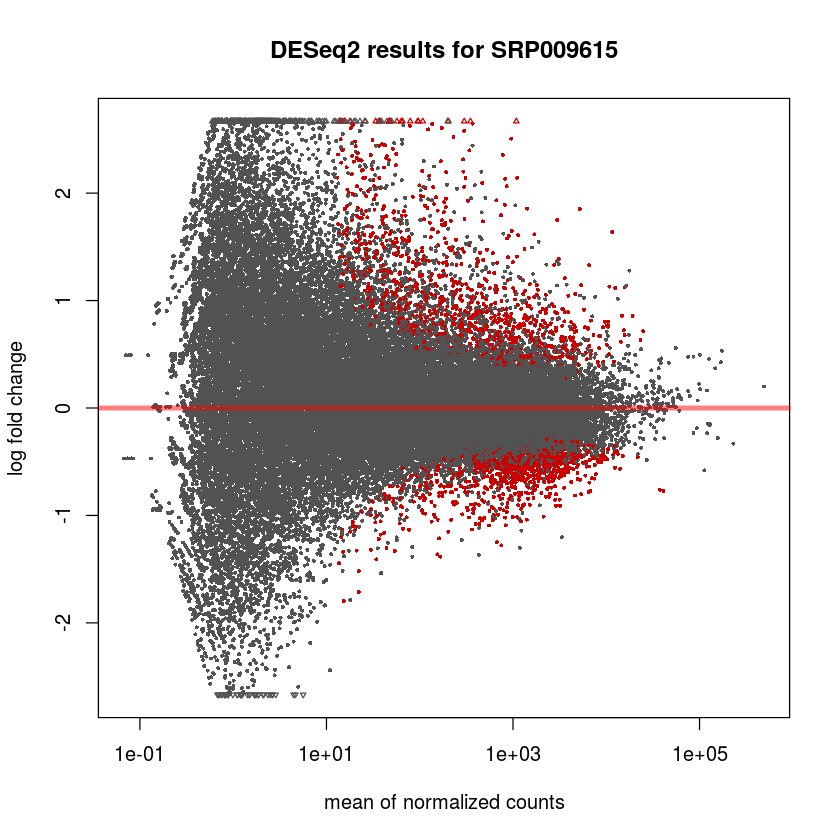

In [16]:
plotMA(res, main="DESeq2 results for SRP009615")

### Create set for clustering

In [391]:
## Extract Gencode gene ids
gencode <- gsub('\\..*', '', names(recount_genes))

## Find the gene information we are interested in
gene_info <- select(org.Hs.eg.db, gencode, c('ENTREZID', 'GENENAME', 'SYMBOL',
    'ENSEMBL'), 'ENSEMBL')


'select()' returned many:many mapping between keys and columns


In [481]:
#Keep values for generating rankfiles later
fold_changes <- data.frame(rownames(res),res$log2FoldChange)
p_values <- data.frame(rownames(res),res$pvalue)

In [482]:
#previous, 0.025, 1 fold change
genes_in_sample <- rownames(res[res$pvalue <= 0.05 & res$log2FoldChange >= 0.5,])

In [484]:
dds <- dds[rownames(dds) %in% genes_in_sample,]

In [485]:
rse_for_collapsing <- rse[rownames(rse) %in% genes_in_sample,]

In [486]:
cluster_set<- collapseReplicates(rse_for_collapsing, groupby = rse_for_collapsing$comp)

In [487]:
cluster_set <- DESeqDataSet(cluster_set, ~ gene_target + group)

In [488]:
norm_cluster_set <- varianceStabilizingTransformation(cluster_set, blind=TRUE)

In [489]:
write.table(assay(norm_cluster_set), file="norm_cluster_set.dat", sep=" ", col.names = T, row.names = T)

In [490]:
datrna <- read.table('norm_cluster_set.dat',row.names= NULL)

In [491]:
datrna$row.names <- do.call(rbind, strsplit(datrna$row.names,"\\."))[,1]

In [492]:
datrna <- datrna[datrna$row.names %in% gene_info$ENSEMBL,]

In [493]:
gene_info_red <- gene_info[,c(1,4)]

In [494]:
colnames(datrna)[1] <- 'ENSEMBL'

In [495]:
datrna <- merge(gene_info_red, datrna, by='ENSEMBL')

In [496]:
## Remove duplicates; these must be later collapsed in a statistically significant metric
datrna <- datrna[!duplicated(datrna$SYMBOL),]

In [497]:
datrna <- datrna[is.na(datrna$SYMBOL) == F,]

In [380]:
for_printing <- datrna[c(6,7,8,3,4,5)]

In [381]:
write.table(for_printing, file='RNASEQdata2.txt' , sep=" ", col.names = F, row.names=F)

In [339]:
#library('regionReport')
#DESeq2Report(dds, res = res, project = 'SRP009615',
    #intgroup = c('group', 'gene_target'), outdir = '.',
    #output = 'SRP009615-results')


#### Generate Rankfile for GSEA

In [499]:
genes_on_set <- data.frame(datrna[,c(1,2)])
colnames(genes_on_set)[1] <- 'transcript'

In [513]:
#Fix names
p_values$transcript <- do.call(rbind, strsplit(as.character(p_values$rownames.res.),"\\."))[,1]
p_values <- p_values[,-1]

In [519]:
rnkfile <- merge(p_values,genes_on_set,by='transcript')
rnkfile <- data.frame(rnkfile[,c(3,2)])

In [521]:
write.table(rnkfile, file="rnkfile.rnk", quote=F, sep="\t", row.names=F, col.names=F)